# Whole-exome sequencing mutations

In [2]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
options(repr.plot.width=8, repr.plot.height=8)

# read switch information
switches <- read_tsv("../data/pancancer/candidateList_info.agg.tsv")

# read mutual exclusion info
wes <- read_tsv("../data/pancancer/mutations/gene_functional_mutations_all_switches.txt") %>%
    transform(co=MS/(MS+S)) %>%
    merge(switches,all=T)

## Overview

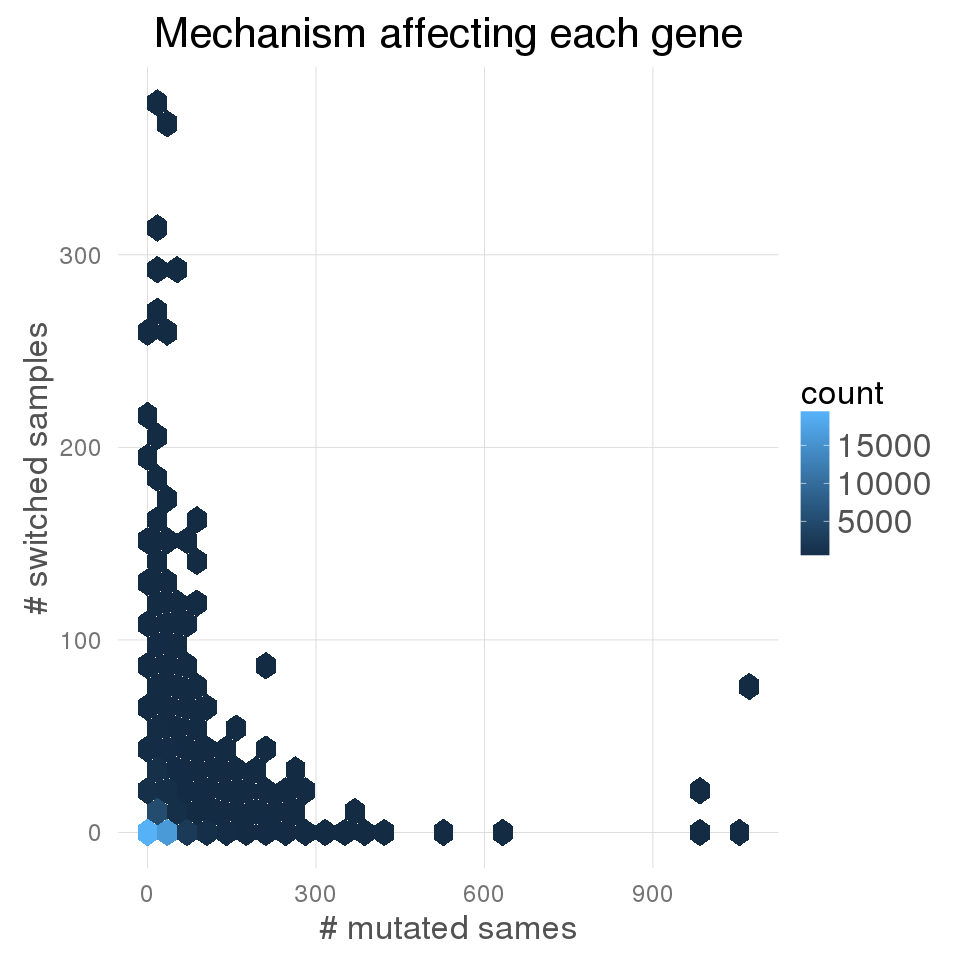

In [3]:
ggplot(wes, aes(x=M+MS,y=S+MS)) + 
    stat_binhex() +
    labs(x="# mutated sames",y="# switched samples",title="Mechanism affecting each gene") +
    smartas_theme() +
    theme(legend.position="right")

Density plot of the different genes. Genes with no switch apprear only one, with its count of mutations and 0 switches. Genes with switches appear as many times as switches there are. For example TP53 appears four times (the four right-most dots). As we can see, switches and mutations rarely co-occur.

In [3]:
cor(wes$M,wes$S,method="pearson")

[1] -0.02052186

As we see, there is no correlation between switches and mutations.

## Co-occurrence
We will focus on cases where a functional switch has been described.

In [19]:
wes <- subset(wes,IsFunctional==1)

# check if co-occurrence in drivers is higher than in non-drivers
wilcox.test(wes$co[wes$Driver==1],wes$co[wes$Driver==0],alternative="greater")

summary(wes$co[wes$Driver==1])
summary(wes$co[wes$Driver==0])


	Wilcoxon rank sum test with continuity correction

data:  wes$co[wes$Driver == 1] and wes$co[wes$Driver == 0]
W = 35132000, p-value = 7.626e-07
alternative hypothesis: true location shift is greater than 0


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
0.00000 0.00000 0.00000 0.01498 0.00000 1.00000     299 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.0000  0.0000  0.0083  0.0000  1.0000    2264 

We expect drivers to harbour more mutations, which in turn could cause switches. Indeed, we observe that switches in drivers tend to co-occur with mutations slightly more than in non-drivers. This suggests that the mutations in cancer can have an impact on splicing.

## Mutual exclusion
We are interested in functional equivalence between switches and mutations. Highly mutually exclusive switches could give us hints regarding this. Genes with high counts of mutations and switches, as well as low counts of co-occurences could be a good indicator of functional equivalence.

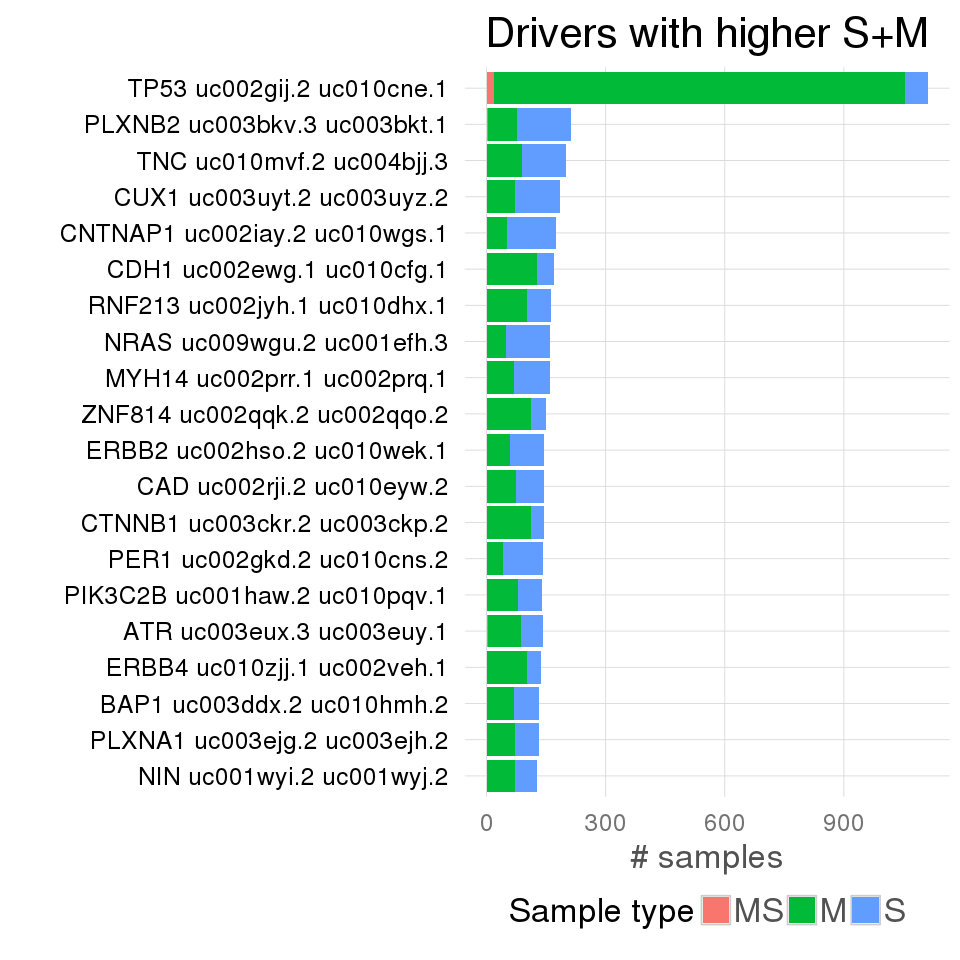

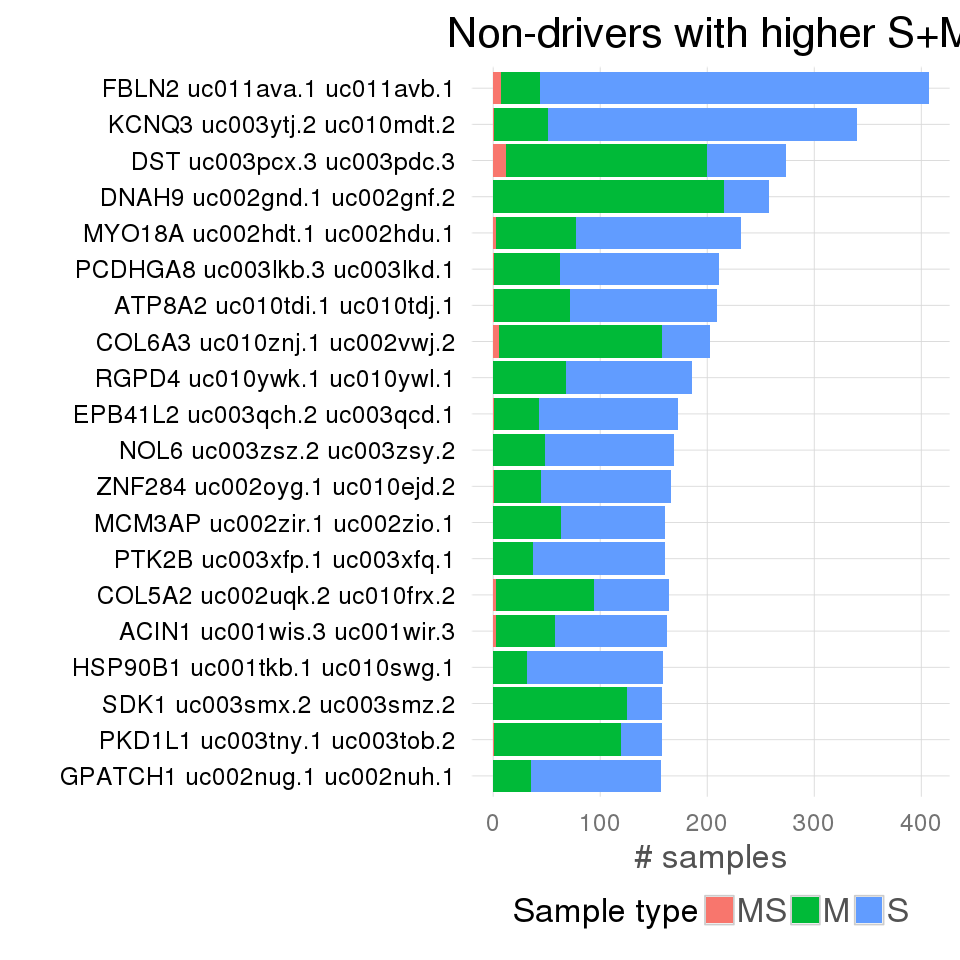

In [4]:
# remove very long genes and cases with few switches or mutations
df <- subset(wes, M > 30 & S > 30 & ! Symbol %in% c("TTN","OBSCN"))

# we order according to M+S and create the factors
df <- df[order(df$M + df$S),] %>%
    transform(Switch=paste(Symbol,Normal_transcript,Tumor_transcript,sep=" ")) %>%
    transform(Switch=factor(Switch,levels=Switch))

# plot top 20 drivers
tail(df[df$Driver==1,],n=20) %>%
    subset(select=c("Switch","MS","M","S")) %>%
    melt(id.vars=c("Switch")) %>%
    subset(value!=0) %>%
    ggplot() + 
    geom_bar(aes(x=Switch,y=value, fill=variable),stat="identity") +
    coord_flip() +
    labs(x="", y="# samples", fill="Sample type", title="Drivers with higher S+M") +
    smartas_theme() +
    theme(text = element_text(size=20), legend.position="bottom", 
          axis.text.y=element_text(hjust=1,vjust=0.5,colour="black"))

# plot top 20 non-drivers
tail(df[df$Driver==0,],n=20) %>%
    subset(select=c("Switch","MS","M","S")) %>%
    melt(id.vars=c("Switch")) %>%
    subset(value!=0)  %>%
    ggplot() + 
    geom_bar(aes(x=Switch,y=value, fill=variable),stat="identity") +
    coord_flip() +
    labs(x="", y="# samples", fill="Sample type", title="Non-drivers with higher S+M") +
    smartas_theme() +
    theme(text = element_text(size=20), legend.position="bottom", 
          axis.text.y=element_text(hjust=1,vjust=0.5,colour="black"))